In [1]:
import relaxed
import jax.numpy as jnp
import pyhf
from jax import grad, jit, vmap
import copy
from functools import partial


def correlated_background(signal, bkg, bkg_up, bkg_down):
    spec = {
        "channels": [
            {
                "name": "single_channel",
                "samples": [
                    {
                        "name": "signal",
                        "data": signal,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": bkg,
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {"hi_data": bkg_up, "lo_data": bkg_down},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(spec, validate=False)


def make_yields(pars):
    bounded_pars_upper = jnp.where(pars > 10.0, 10.0, pars)
    bounded_pars = jnp.where(bounded_pars_upper < -10.0, -10.0, bounded_pars_upper)
    u1, d1 = bounded_pars
    u = jnp.array([u1, -u1])
    d = jnp.array([d1, -d1])

    sig = jnp.array([5, 11])
    nominal = jnp.array([50, 50])
    up = jnp.array([50, 50]) + u
    down = jnp.array([50, 50]) + d

    return sig, nominal, up, down


def setup_cls():
    model = correlated_background(*[jnp.ones(2)] * 4)

    def pipeline_cls(pars):
        sig, bkg, bkg_up, bkg_down = make_yields(pars)
        # print(sig, bkg, bkg_up, bkg_down)
        model.main_model.nominal_rates = jnp.stack([bkg, sig]).reshape(
            model.nominal_rates.shape
        )
        model.main_model.modifiers_appliers["histosys"]._histosys_histoset = [
            [[bkg_up, bkg, bkg_down], [sig] * 3]
        ]
        return model
        nominal = (
            jnp.array(model.config.suggested_init()).at[model.config.poi_index].set(0.0)
        )
        data = model.expected_data(nominal)
        cls_val = relaxed.infer.hypotest(
            1.0, data, model, lr=1e-3, expected_pars=nominal
        )

        return cls_val

    return pipeline_cls


p = setup_cls()
model = p(jnp.array([5, -3]))
m = correlated_background(*make_yields(jnp.array([5, -3])))
data = m.expected_data(jnp.array([1, 1]))
pdfreal = partial(lambda pars, data: m.logpdf(pars, data)[0], data=data)
pdfmod = partial(lambda pars, data: model.logpdf(pars, data)[0], data=data)

# def pipeline_p0(a,b):
#     model = make_model(jnp.array([a,b]))
#     nominal = jnp.array(model.config.suggested_init())
#     data = model.expected_data(nominal)
#     p0 = relaxed.infer.hypotest(0., data, model, test_stat='q0', lr=1e-3, expected_pars=nominal)
#     return p0


def update_model(m, sig, bkg, bkg_up, bkg_down):
    # m = copy.deepcopy(model)
    m.main_model.nominal_rates = jnp.stack([bkg, sig]).reshape(
        m.main_model.nominal_rates.shape
    )
    m.main_model.modifiers_appliers["histosys"]._histosys_histoset = [
        [[bkg_up, bkg, bkg_down], [sig] * 3]
    ]

AttributeError: 'ShapedArray' object has no attribute 'tolist'

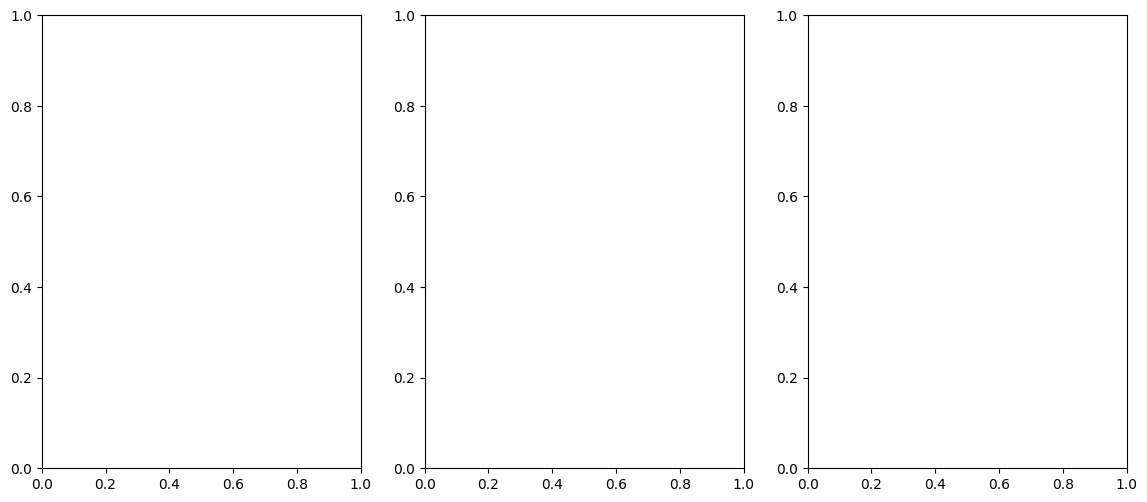

In [2]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(14, 6), dpi=100)

fig, axs = plt.subplots(1, 3)
levels = jnp.linspace(-250, 10, 30)
init = jnp.linspace(0, 10, 1000)
# make a meshgrid
X, Y = jnp.meshgrid(init, init)
# stack into a single matrix
XY = jnp.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
real = vmap(pdfreal)(XY)
mod = vmap(pdfmod)(XY)

a = axs[0].contourf(X, Y, real.reshape(X.shape), cmap="viridis", levels=levels)
axs[0].set_title("Model from scratch")
axs[0].set_ylabel("$\mu$")
axs[0].set_xlabel("$\gamma$")
axs[1].contourf(X, Y, mod.reshape(X.shape), cmap="viridis", levels=levels)
axs[1].set_title("Hacked model, initialised with ones")
axs[1].set_ylabel("$\mu$")
axs[1].set_xlabel("$\gamma$")
axs[2].contourf(
    X, Y, real.reshape(X.shape) - mod.reshape(X.shape), cmap="viridis", levels=levels
)
axs[2].set_title("Difference")
axs[2].set_ylabel("$\mu$")
axs[2].set_xlabel("$\gamma$")
fig.colorbar(a, ax=axs.ravel().tolist(), orientation="horizontal")
plt.suptitle("Log-likelihoods, simple histosys model")

In [3]:
model.config.poi_index

1

In [28]:
pyhf.set_backend("jax", default=False)
init = jnp.linspace(-10, 10, 100)
# make a meshgrid of the initial parameters
X, Y = jnp.meshgrid(init, init)
# reshape into x,y pairs
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
# stack into a single matrix
XY = jnp.hstack([X, Y])


p = setup_cls()
# vmap over pairs
ps = vmap(p)(XY)
ps[ps <= 0.26]

DeviceArray([], dtype=float64)

In [3]:
correlated_background(*[jnp.ones(2)] * 4).main_model.nominal_rates

DeviceArray([[[[1., 1.]],

              [[1., 1.]]]], dtype=float64)